<a href="https://colab.research.google.com/github/Azaidi317/Segmentation-SAM/blob/main/Meta_SAM_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0twpisxu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0twpisxu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=31d022174232062e4f67d0786f1d1412ad3ffb21c1a8c6c31b9dd34b6eeafefd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ziy1oxk9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-27 08:56:13--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.19, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   218MB/s    in 11s     

2024-11-27 08:56:24 (214 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00


Loading SAM model...
Please upload your image...
Upload an image...


Saving human+dog.jpeg to human+dog (3).jpeg


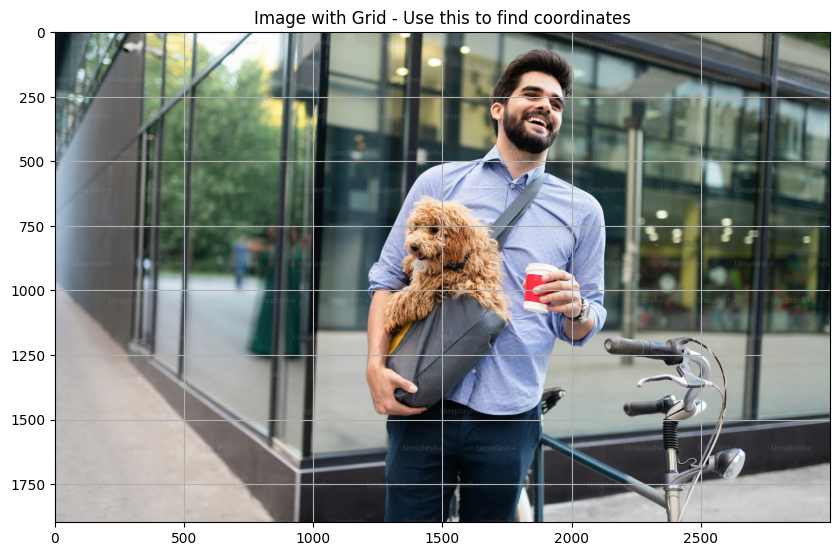

Image shape (height, width): (1898, 3000)

Looking at the image above, enter the coordinates where you want to segment:
Enter X coordinate: 1500
Enter Y coordinate: 750


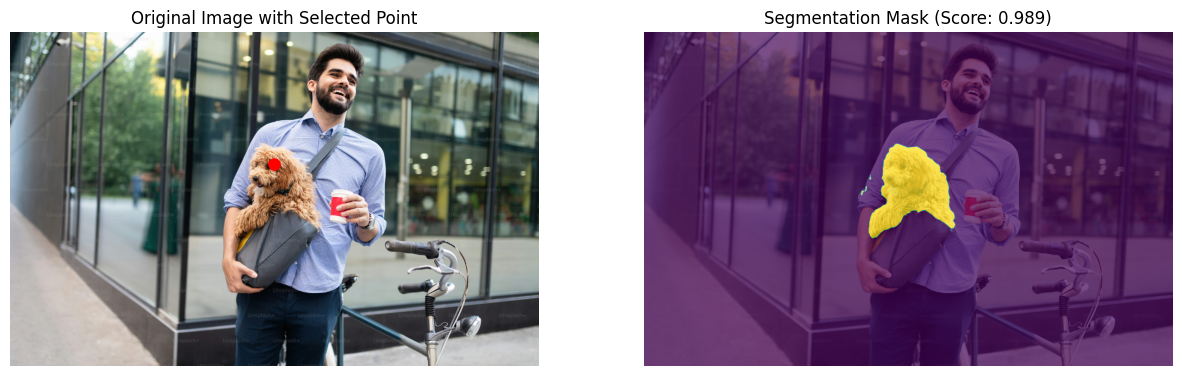

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor
from google.colab import files
from IPython.display import display
from PIL import Image

def load_sam():
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    MODEL_TYPE = "vit_h"
    CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)
    predictor = SamPredictor(sam)
    return predictor

def upload_and_show_image():
    print("Upload an image...")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Read and convert image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image with pixel coordinates
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.grid(True)
    plt.title("Image with Grid - Use this to find coordinates")
    plt.show()

    print(f"Image shape (height, width): {image.shape[:2]}")
    return image

def segment_with_coordinates(predictor, image, input_point):
    # Set the image in the predictor
    predictor.set_image(image)

    # Prepare point coordinates
    input_point = np.array([input_point])
    input_label = np.array([1])

    # Generate masks
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )

    # Visualize results
    plt.figure(figsize=(15, 5))

    # Original image with point
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.plot(input_point[0][0], input_point[0][1], 'ro', markersize=8)
    plt.title("Original Image with Selected Point")
    plt.axis('off')

    # Mask with highest score
    best_mask_idx = np.argmax(scores)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(masks[best_mask_idx], alpha=0.7, cmap='viridis')
    plt.title(f"Segmentation Mask (Score: {scores[best_mask_idx]:.3f})")
    plt.axis('off')
    plt.show()

    return masks, scores

# Main execution
print("Loading SAM model...")
predictor = load_sam()

print("Please upload your image...")
image = upload_and_show_image()

# Get coordinates from user
print("\nLooking at the image above, enter the coordinates where you want to segment:")
x_coord = int(input("Enter X coordinate: "))
y_coord = int(input("Enter Y coordinate: "))

# Perform segmentation
masks, scores = segment_with_coordinates(predictor, image, [x_coord, y_coord])